# Regression model

In [1]:
%matplotlib inline

In [4]:
# use the pymc version 3.9
!pip install --upgrade pymc3==3.9

Requirement already up-to-date: pymc3==3.9 in /usr/local/lib/python3.6/dist-packages (3.9.0)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
import json
import nltk
from datetime import datetime
import pymc3 as pm, theano.tensor as tt

In [6]:
# import feature vectors
data = pd.read_csv('pnd_features.csv', index_col=0)

In [7]:
# channel id
data['channel'] = data['channel'].factorize()[0]

In [8]:
# interaction variables
data['volume_yobit'] = data['relative_volume'] * data['yobit']
data['coin_yobit'] = data['coin_cap'] * data['yobit']

In [9]:
# dependent and indepenedet variables
y = data['theoretical_return'].values
x = data[['subscriber_0901', 'duration', 'relative_volume', 'coin_cap', 'volume_yobit', 'coin_yobit']]
dummy = data[['yobit', 'bittrex', 'year']].reset_index(drop=True)

In [10]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x)
x_ss = ss.transform(x)
x_ss = pd.DataFrame(x_ss, columns= x.columns)

In [11]:
# standard scaler for feature vector (except dummy variables)
x = x_ss.merge(dummy,right_index=True, left_index=True)
x = x.reindex(columns=['subscriber_0901', 'duration', 'relative_volume','coin_cap', 'yobit', 'bittrex', 'year', 'volume_yobit', 'coin_yobit'])

In [12]:
# Normal distribution
n, k  = x.shape
b0 = np.zeros(k)
tau0 = 0.01 * np.eye(k)


with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coef = pm.MvNormal('beta', mu=b0, tau=tau0, shape=k)

    # telegram channel effect
    tau = pm.HalfCauchy('tau', 5)
    eta = pm.Normal('eta', mu=0, sigma=tau, shape=len(data['channel'].unique()))

    # regression
    eq = intercept +  eta[data['channel'].values] + pm.math.dot(x, coef)
    sigma = pm.HalfCauchy('sigma', 5)
    
    # normal distribution
    est = pm.Normal('y', mu=eq, sigma= sigma, observed=pm.math.log(y))
    
# sampling
with model:
    # get sample from 3001th, three chains
    trace = pm.sample(7000, tune=3000, chains = 3, random_seed=0)

pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (3 chains in 1 job)
NUTS: [sigma, eta, tau, beta, intercept]


Sampling 3 chains for 3_000 tune and 7_000 draw iterations (9_000 + 21_000 draws total) took 99 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,-0.008,0.046,-0.092,0.080,0.000,0.000,14756.0,13342.0,14776.0,14966.0,1.0
beta[0],-0.012,0.023,-0.056,0.032,0.000,0.000,21502.0,14832.0,21494.0,15322.0,1.0
beta[1],0.003,0.015,-0.025,0.031,0.000,0.000,31661.0,11697.0,31691.0,16709.0,1.0
beta[2],-0.002,0.013,-0.026,0.023,0.000,0.000,48222.0,7731.0,48141.0,15015.0,1.0
beta[3],-0.004,0.017,-0.036,0.028,0.000,0.000,30224.0,10171.0,30227.0,15860.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
eta[95],-0.016,0.127,-0.259,0.219,0.001,0.001,43722.0,7777.0,43696.0,14944.0,1.0
eta[96],-0.003,0.128,-0.250,0.233,0.001,0.001,40843.0,6663.0,40802.0,13253.0,1.0
eta[97],-0.018,0.131,-0.266,0.233,0.001,0.001,44924.0,7108.0,44939.0,13945.0,1.0
tau,0.141,0.022,0.099,0.183,0.000,0.000,4307.0,4307.0,4217.0,5912.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<Figure size 576x576 with 0 Axes>

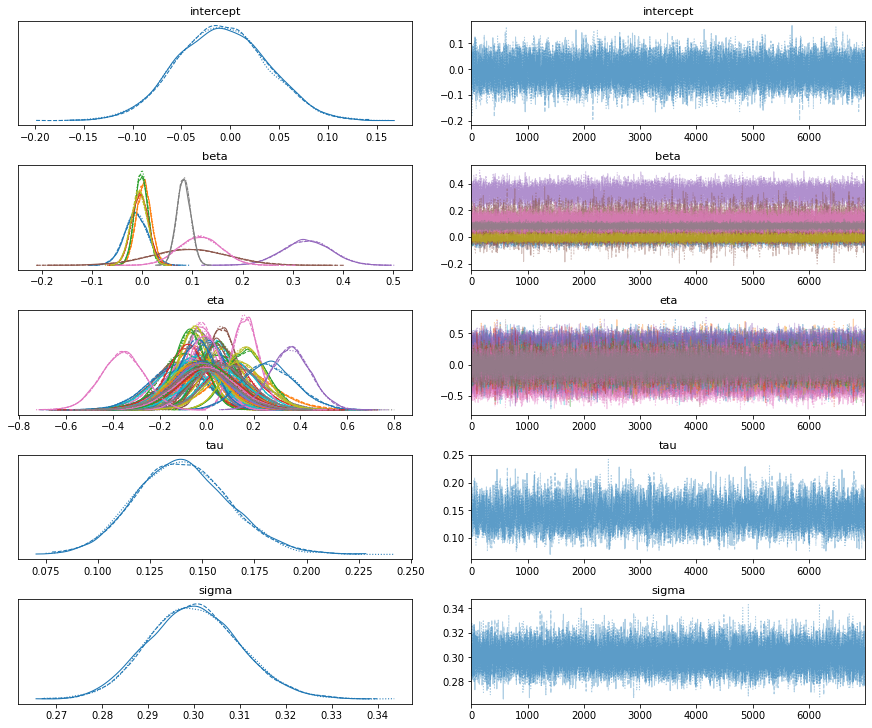

In [13]:
plt.figure(figsize=(8, 8))
pm.traceplot(trace)
plt.savefig('img/trace.jpg')

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


1.0
1.0


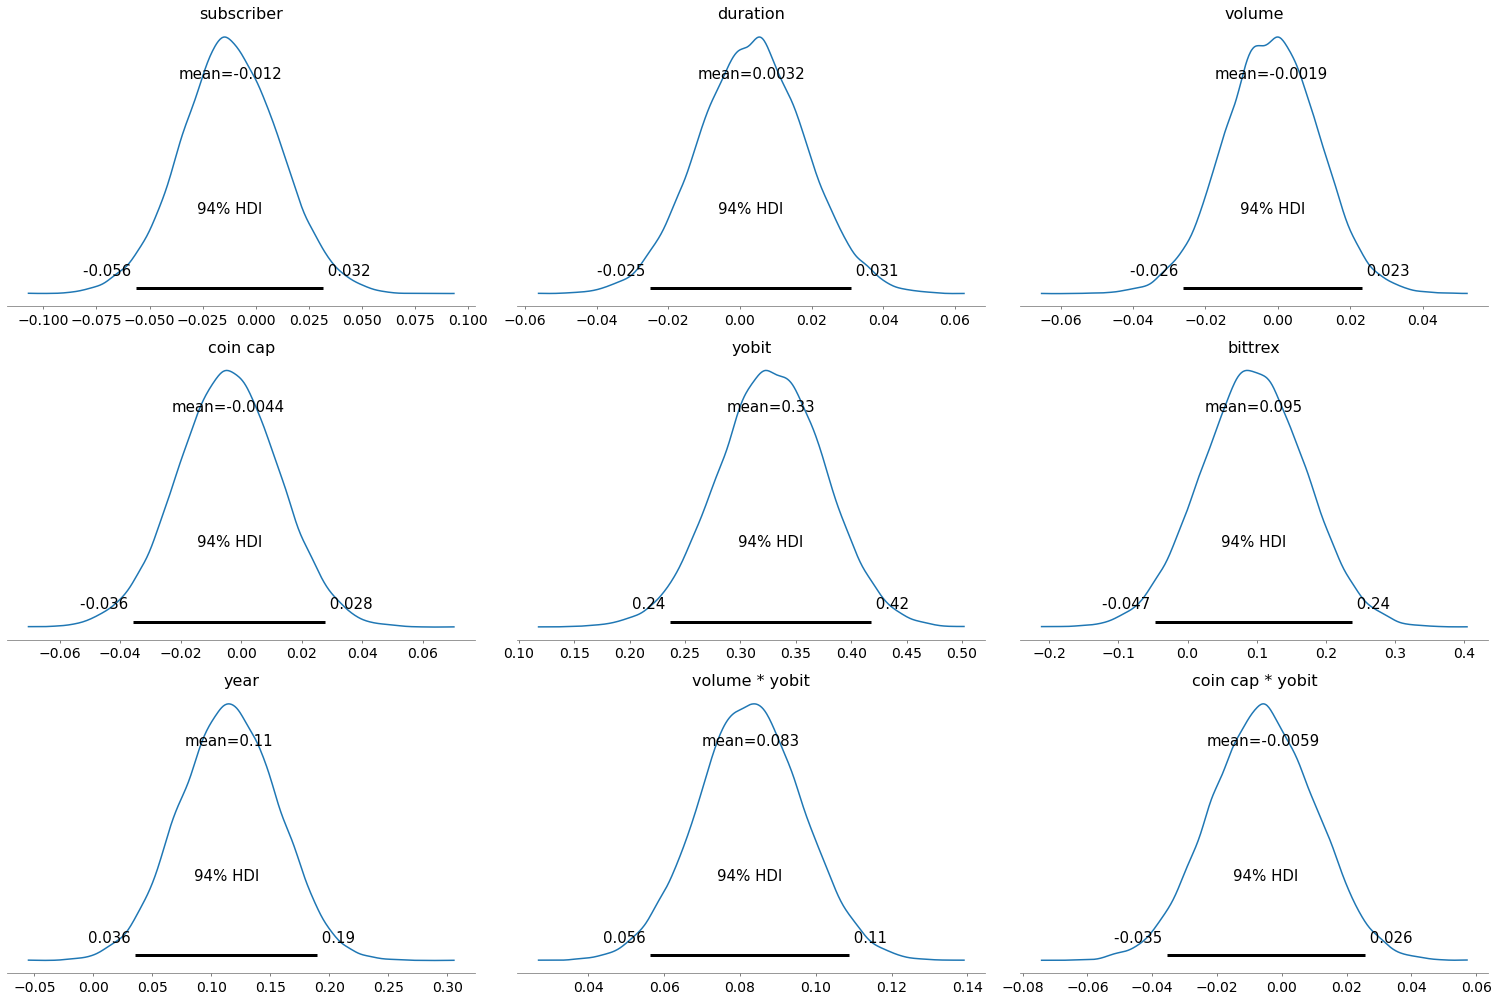

In [14]:
# check r hat and HPDI
rhat = pm.summary(trace)['r_hat']
print(min(rhat))
print(max(rhat))
var_names = ['subscriber', 'duration', 'volume','coin cap','yobit', 'bittrex',  'year', 'volume * yobit', 'coin cap * yobit']
sim_param = dict([('{}'.format(var_names[i]), trace['beta'][:,i]) for i in range(k)])
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


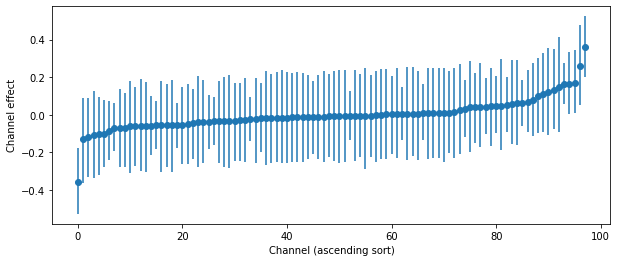

In [15]:
# telegram channel effect ascending order
df_hpd = pd.DataFrame(pm.stats.hpd(trace['eta']),
                      columns=['hpd_low', 'hpd_high'])
df_median = pd.DataFrame(np.quantile(trace['eta'], 0.5, axis=0),
                         columns=['hpd_median'])
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.index, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_xlabel('Channel (ascending sort)')
axs.set_ylabel('Channel effect')
plt.savefig('img/channel_effect.jpg')

In [16]:
# export summary table
betas = []
for i in range(k):
  betas.append('beta[{}]'.format(i))
table = pm.summary(trace).loc[betas]
table.index = var_names
hpd = pm.stats.hpd(trace['beta'])
hpd = pd.DataFrame(hpd, index=var_names, columns=['hpd1', 'hpd2'])
table = table[['mean', 'sd', 'r_hat']].merge(hpd, right_index=True, left_index=True)
pd.options.display.precision = 3
display(table)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


,mean,sd,r_hat,hpd1,hpd2
subscriber,-0.012,0.023,1.0,-0.056,0.032
duration,0.003,0.015,1.0,-0.025,0.031
volume,-0.002,0.013,1.0,-0.026,0.023
coin cap,-0.004,0.017,1.0,-0.036,0.028
yobit,0.327,0.048,1.0,0.237,0.418
bittrex,0.095,0.076,1.0,-0.047,0.237
year,0.115,0.041,1.0,0.036,0.190
volume * yobit,0.083,0.014,1.0,0.056,0.109
coin cap * yobit,-0.006,0.016,1.0,-0.035,0.026
